In [1]:
import json
import time
import os
import re
import shlex
import subprocess
import platform
from docker import from_env as docker_client
from dataclasses import dataclass
from datetime import datetime
from configparser import ConfigParser

import pandas as pd
import psycopg

In [28]:
#loading config
def load_config(filename="database.ini", section="postgresql"):
    parser = ConfigParser()
    parser.read(filename)

    config = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            config[param[0]] = param[1]
    else:
        raise Exception("Section {0} not found in the {1} file".format(section, filename))
    return config

#connecting to db
def connect():
    try:
        pg_conn = psycopg.connect(**load_config(), connect_timeout = 5)
        return pg_conn
    except psycopg.DatabaseError as error:
        raise error

#disconnecting from db
def disconnect(pg_conn, cursor = None):
    if cursor != None:
        cursor.close()
    pg_conn.close()

In [29]:
#restart db and remove cache if possible
def restart_db():
    env = load_config(section = "docker")

    if env["container_name"] != "":
        try:
            client = docker_client()
            container = client.containers.get(env["container_name"])

            container.stop()
            container.wait()
            container.start()
            
        except Exception as e:
            print(e)
            
    elif platform.system() == "Linux":
        try:
            subprocess.run(['sudo', 'systemctl', 'stop', 'postgresql'], check=True)

            subprocess.run(["sync"], check=True)
            subprocess.run(["sudo", "sh", "-c", "echo 3 > /proc/sys/vm/drop_caches"], check=True)
            
            subprocess.run(['sudo', 'systemctl', 'start', 'postgresql'], check=True)

        except Exception as e:
            print(e)

    else:
        raise Exception("System configuration not supported")

#wait for db to accept connections
def wait_for_db(timeout = 15):
    start = time.time()

    while time.time() - start < timeout:
        try:
            pg_conn = connect()
            cursor = pg_conn.cursor()

            disconnect(pg_conn, cursor)
            return
        except psycopg.OperationalError:
            time.sleep(1)
    raise TimeoutError("Could not connect to the database")

In [67]:
@dataclass
class Query:
    label: str
    string: str
    groups: list[str]

#formatting query
def format_query(query):
    #removing comments
    query = re.sub(r"--.*", "", query)
    query = re.sub(r"/\*.*?\*/", "", query, flags = re.DOTALL)
    query = re.sub(r"EXPLAIN (ANALYZE|(\(.*\)))", "", query) #fallback for explain
    
    #joining words with spaces while preserving quoted strings
    query = " ".join(shlex.split(query, posix = False))

    return query

queries: list[Query] = []

#loading all queries
for root, dirs, files in os.walk(os.curdir):
    for file in files:
        if not file.endswith(".sql"):
            continue

        path = os.path.join(root, file)
        
        query = open(path, "r").read()
        query = format_query(query)

        groups = root.removeprefix(".").removeprefix(os.sep).split(os.sep)

        query = Query(file, query, groups)

        queries.append(query)
        print(query)

Query(label='lag_rank.sql', string="WITH posts_date_table AS ( SELECT TO_CHAR(posts.creationdate, 'YYYY-MM' ) AS year_month, creationdate - LAG(creationdate) OVER (ORDER BY creationdate) AS time_diff, LENGTH(posts.body) AS length FROM posts ), comments_date_table AS ( SELECT TO_CHAR(comments.creationdate, 'YYYY-MM' ) AS year_month, creationdate - LAG(creationdate) OVER (ORDER BY creationdate) AS time_diff, LENGTH(comments.text) AS length FROM comments ), postings_date_table AS ( SELECT year_month, time_diff, length FROM posts_date_table UNION ALL SELECT year_month, time_diff, length FROM comments_date_table ORDER BY year_month ) SELECT year_month, COUNT(*) AS num_postings, AVG(time_diff) AS avg_time_diff, AVG(length) AS avg_length FROM postings_date_table GROUP BY year_month;", groups=[''])
Query(label='count_rank.sql', string='SELECT u.id, displayname, COUNT(*) AS post_count, RANK() OVER (ORDER BY COUNT(*) DESC) AS rank FROM users u JOIN posts p ON p.owneruserid = u.id GROUP BY u.id;'

In [49]:
@dataclass
class QueryResult:
    label: str
    groups: list[str]
    query: str
    bench_time: datetime
    result_set: dict
    exec_time: float

#executes given query and returns QueryResult object
def run_query(query, cursor, analyze_prefix = ""):

    bench_start, query_start = datetime.now(), time.perf_counter_ns()
    cursor.execute(analyze_prefix + query.string)

    result_set = cursor.fetchall()
    query_end = time.perf_counter_ns()

    result = QueryResult(
        label = query.label,
        groups = query.groups,
        query = query.string,
        bench_time = bench_start,
        result_set = json.dumps(result_set),
        exec_time = query_end - query_start
    )

    return result

#executes query with precaching and returns list of results
def hot_run_query(query, precache_repeats = 3, query_repeats = 1, analyze_prefix = ""):
    
    results: list[QueryResult] = []

    pg_conn = connect()
    cursor = pg_conn.cursor()
    
    for statement in query.string.split(";"):
        statement = statement.strip()

        if statement == "":
            continue

        if statement.upper().startswith(("CREATE", "REPLACE", "REFRESH", "DROP")):
            cursor.execute(statement)
            continue

        for _ in range(precache_repeats):
            cursor.execute(statement)
        
        new_query = Query(query.label, statement, query.groups)

        for _ in range(query_repeats):
            result = run_query(new_query, cursor, analyze_prefix)
            results.append(result)

    disconnect(pg_conn, cursor)

    return results

#executes query without precaching and returns list of results
def cold_run_query(query, query_repeats = 1, analyze_prefix = ""):

    results: list[QueryResult] = []
    
    for _ in range(query_repeats):

        restart_db()
        wait_for_db()

        pg_conn = connect()
        cursor = pg_conn.cursor()

        for statement in query.string.split(";"):
            statement = statement.strip()

            if statement == "":
                continue

            if statement.upper().startswith(("CREATE", "REPLACE", "REFRESH", "DROP")):
                cursor.execute(statement)
                continue

            new_query = Query(query.label, statement, query.groups)
            
            result = run_query(new_query, cursor, analyze_prefix)
            results.append(result)

        disconnect(pg_conn, cursor)

    return results

In [69]:
#execution settings
analyze_prefix = "EXPLAIN (ANALYZE, FORMAT JSON, SETTINGS) "
only_run = ["jsonb_compare_1a.sql", "jsonb_compare_1b.sql"] #full label or group name
precache_repeats = 3
query_repeats = 10
cold_run = False

In [70]:
# executing queries
results: list[QueryResult] = []

for query in queries:

    if (
        len(only_run) > 0
        and query.label not in only_run
        and not any(group in only_run for group in query.groups)
    ):
        continue

    print(query.label)

    if cold_run:
        result = cold_run_query(query, query_repeats, analyze_prefix)
    else:
        result = hot_run_query(query, precache_repeats, query_repeats, analyze_prefix)

    results.extend(result)

jsonb_compare_1a.sql
jsonb_compare_1b.sql


In [71]:
#saving results
file_name = "json_results"

if cold_run:
    file_name += "_cold"
else:
    file_name += "_hot"

df = pd.DataFrame(results)
df.to_csv(file_name + ".csv", index = False)

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
#plotting results
sns.set_context("talk")
sns.set_palette("viridis")
sns.set_theme(style = "whitegrid")

In [72]:
df = pd.read_csv("json_results_hot.csv")

def getTotalCost(text):
    match = re.search(r'"Total Cost": (\d+)', text)
    return int(match.group(1)) if match else None

df["Total Cost"] = df["result_set"].apply(getTotalCost)

df["Cost per Time"] = df["Total Cost"]/df["exec_time"]
df["Time per Cost"] = df["exec_time"]/df["Total Cost"]

df["Json"] = "json" in df["label"]

print(df.describe())

          exec_time    Total Cost  Cost per Time  Time per Cost
count  2.000000e+01     20.000000      20.000000      20.000000
mean   1.591392e+09  64436.500000       0.000054   24689.800026
std    8.155889e+08     39.500167       0.000027   12642.119925
min    7.896381e+08  64398.000000       0.000023   12261.841501
25%    8.130216e+08  64398.000000       0.000028   12624.951035
50%    1.517544e+09  64436.500000       0.000054   23544.597432
75%    2.273077e+09  64475.000000       0.000079   35255.162807
max    2.862628e+09  64475.000000       0.000082   44399.033517


In [61]:
import json

def extract_plans(plan, results=None):
    if results is None:
        results = []
    
    # Store the current plan excluding the "Plans" key
    filtered_plan = {k: v for k, v in plan.items() if k != "Plans"}
    results.append(filtered_plan)
    
    # If "Plans" exists and is a list, process each sub-plan recursively
    if "Plans" in plan and isinstance(plan["Plans"], list):
        for sub_plan in plan["Plans"]:
            extract_plans(sub_plan, results)
    
    return results

In [ ]:
plan_df = pd.DataFrame()

for result_set in df["result_set"]:
    query_plan = json.loads(result_set)[0][0][0]["Plan"]
    # print(extract_plans(query_plan))
    data = extract_plans(query_plan)
    tmp_df = pd.DataFrame(data)
    plan_df = pd.concat([plan_df, tmp_df])


In [43]:
plan_df["runtime"] = plan_df["Actual Total Time"] - plan_df["Actual Startup Time"]
plan_df["cost"] =  plan_df["Total Cost"] - plan_df["Startup Cost"]

plan_df.describe()

NameError: name 'plan_df' is not defined

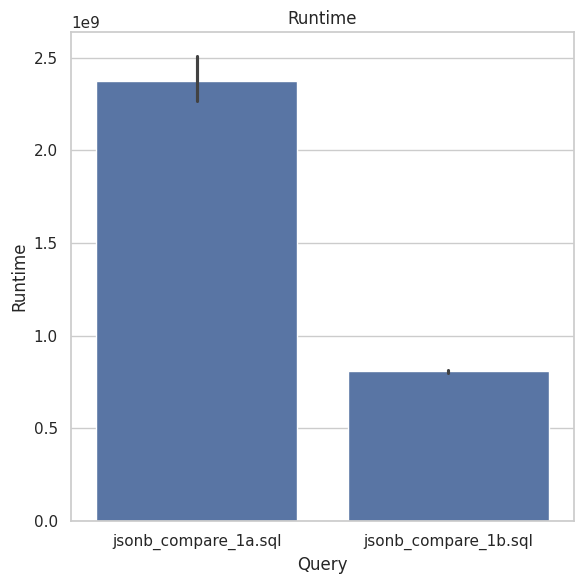

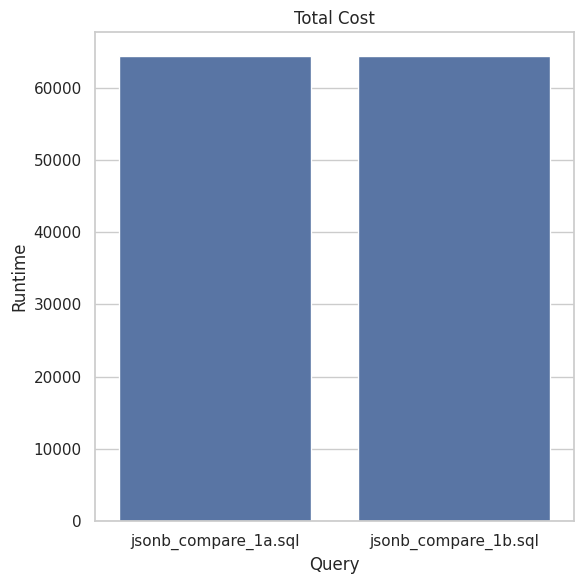

<function matplotlib.pyplot.show(close=None, block=None)>

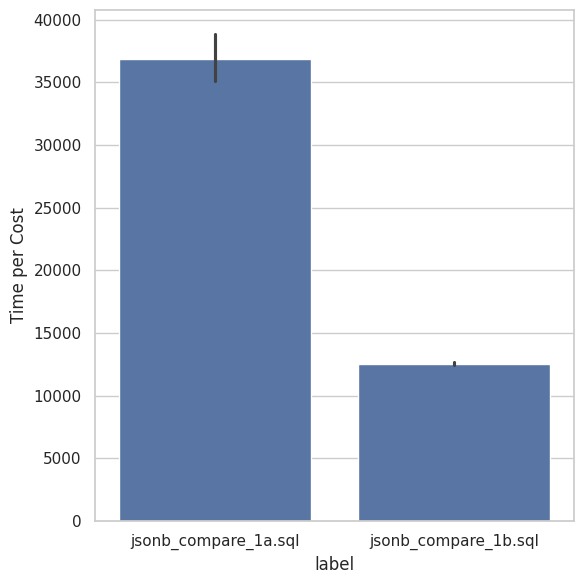

In [73]:
# Json research question
g = sns.barplot(
    data = df,
    x = "label",
    y = "exec_time",
)

g.set(
    title = "Runtime",
    xlabel = "Query",
    ylabel = "Runtime"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.show()

g = sns.barplot(
    data = df,
    x = "label",
    y = "Total Cost",
)

g.set(
    title = "Total Cost",
    xlabel = "Query",
    ylabel = "Runtime"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.show()

g = sns.barplot(
    data = df,
    x = "label",
    y = "Time per Cost",
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.show

In [ ]:
g = sns.regplot(
    data = df,
    x = "Total Cost",
    y = "exec_time",
    scatter = True,
    
)

g.set(
    title = "Runtime per Cost",
    xlabel = "Total Cost",
    ylabel = "Runtime"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.xscale("log")
plt.yscale("log")

plt.show

In [ ]:
g = sns.regplot(
    data = df,
    x = "exec_time",
    y = "Time per Cost",
    scatter = True,
)

g.set(
    title = "Time per Cost to Runtime",
    xlabel = "Runtime",
    ylabel = "Cost per Runtime"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.xscale("log")
plt.yscale("log")

plt.show

In [ ]:
g = sns.regplot(
    data = df,
    x = "Total Cost",
    y = "Time per Cost",
    scatter = True,
)

g.set(
    title = "Time per Cost to Total Cost",
    xlabel = "Total Cost",
    ylabel = "Time per Cost"
)

g.get_figure().set_size_inches(6, 6)
g.get_figure().tight_layout()

plt.xscale("log")
plt.yscale("log")

plt.show

In [ ]:
g = sns.histplot(
    data = plan_df,
    x = "runtime",
    y = "cost",
    hue = "Node Type",
)

g.set(
    title = "Time per Cost to Total Cost",
    xlabel = "Total Cost",
    ylabel = "Time per Cost"
)

plt.xscale("log")
plt.yscale("log")

plt.show

In [ ]:
df = pd.read_csv("results.csv")

df["exec_time"] = df["exec_time"] / 1000000

g = sns.barplot(
    data = df,
    x = "exec_time",
    y = "label"
)

g.set(
    title = "Query runtimes",
    xlabel = "Execution time [ms]",
    ylabel = "Query"
)

g.get_figure().set_size_inches(10, 10)
g.get_figure().tight_layout()

plt.xscale("log")

plt.show()